In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

import os, glob

In [2]:
img_dir = sorted(glob.glob('./lgg-mri-segmentation/kaggle_3m/*'))

In [4]:
IMG_SIZE = 256

image = []
mask = []

for dirc in img_dir:
    img_list = glob.glob(dirc + '/*.tif')
    for img_path in img_list:  
        if 'mask' in img_path:
            img = cv2.imread(img_path, 0)
            if np.sum(img) == 0:
                break
            else:
                img = img.reshape(1, int(IMG_SIZE), int(IMG_SIZE)) / 255
                mask.append(img)

                img_path = img_path.replace('_mask', '')

                img = cv2.imread(img_path, 1)
                img = np.transpose(img, (2, 0, 1))
                img = img / 255
                image.append(img)

image = np.array(image)
mask = np.array(mask)

print(image.shape, mask.shape)

(187, 3, 256, 256) (187, 1, 256, 256)


In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

In [10]:
x_train  =  torch.FloatTensor(image)
y_train  =  torch.FloatTensor(mask)

In [14]:
dataset = TensorDataset(x_train, y_train)
train_set, val_set = torch.utils.data.random_split(dataset, [167, 20])

In [15]:
train_loader = DataLoader(train_set, batch_size=16, shuffle=True)
val_loader = DataLoader(val_set, batch_size=4, shuffle=True)

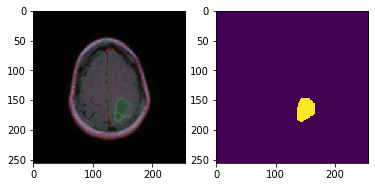

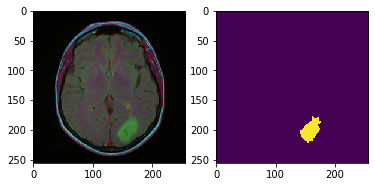

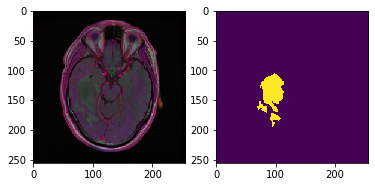

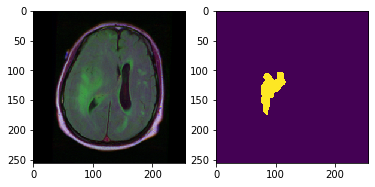

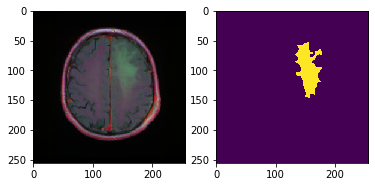

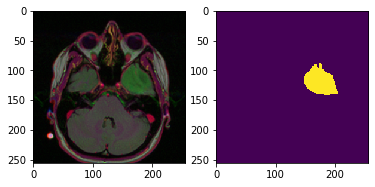

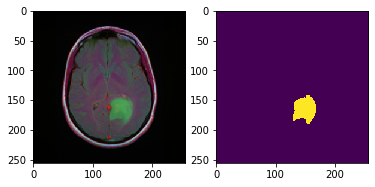

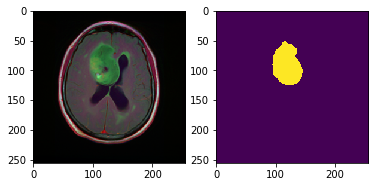

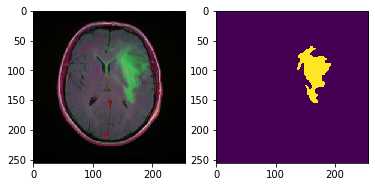

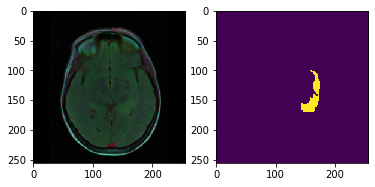

In [21]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision

dataiter = iter(train_loader)
images, labels = dataiter.next()

show_img = (np.transpose(images, (0, 2, 3, 1))).numpy()
show_label = (np.transpose(labels, (0, 2, 3, 1))).numpy()

for i in range(10):
    fig = plt.figure()
    
    npimg = show_img[i]
    nplabel = show_label[i]
    nplabel = nplabel.squeeze()
    
    ax1 = fig.add_subplot(1,2,1)
    ax1.imshow(npimg)
    
    ax2 = fig.add_subplot(1,2,2)
    ax2.imshow(nplabel)
    plt.show()

In [22]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)
        
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)

        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.pool3 = nn.MaxPool2d(2, 2)
        
        self.conv4 = nn.Conv2d(128, 128, 3, padding=1)
        self.pool4 = nn.MaxPool2d(2, 2)
        
        self.dense = nn.Conv2d(128, 128, 1)
        
        self.up5 = nn.Upsample(scale_factor=2)
        self.conv5 = nn.Conv2d(128, 128, 3, padding=1)
        
        self.up6 = nn.Upsample(scale_factor=2)
        self.conv6 = nn.Conv2d(128, 64, 3, padding=1)
        
        self.up7 = nn.Upsample(scale_factor=2)
        self.conv7 = nn.Conv2d(64, 32, 3, padding=1)
        
        self.up8 = nn.Upsample(scale_factor=2)
        self.conv8 = nn.Conv2d(32, 1, 3, padding=1)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = self.pool3(F.relu(self.conv3(x)))
        x = self.pool4(F.relu(self.conv4(x)))
        
        x = self.dense(x)
        
        x = self.conv5(F.sigmoid(self.up5(x)))
        x = self.conv6(F.sigmoid(self.up6(x)))
        x = self.conv7(F.sigmoid(self.up7(x)))
        x = self.conv8(F.sigmoid(self.up8(x)))
        return x


net = Net()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
net.to(device)

cuda:0


Net(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dense): Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1))
  (up5): Upsample(scale_factor=2.0, mode=nearest)
  (conv5): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (up6): Upsample(scale_factor=2.0, mode=nearest)
  (conv6): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (up7): Upsample(sca

In [23]:
import torch.optim as optim

criterion = nn.BCEWithLogitsLoss()

learning_rate = 0.001
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

In [24]:
train_losses, val_losses, accuracy = [], [], []
epochs = 100

for epoch in range(epochs):
    running_loss = 0
    
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    
    else:
        val_loss = 0
        val_accuracy = 0
        
        with torch.no_grad():
            cnt = 0
            
            for val_image, val_label in val_loader:
                val_image, val_label = val_image.to(device), val_label.to(device)
                val_outputs = net(val_image)
                
                val_loss += criterion(val_outputs, val_label)
        
        train_losses.append(running_loss/len(train_loader))
        val_losses.append(val_loss/len(val_loader))

        print("Epoch: {}/{} || ".format(epoch+1, epochs),
              "Training Loss: {:.5f} || ".format(running_loss/len(train_loader)),
              "Val Loss: {:.5f} ".format(val_loss/len(val_loader))
             )

print('Finished Training')

Epoch: 1/100 ||  Training Loss: 0.26479 ||  Val Loss: 0.19557 
Epoch: 2/100 ||  Training Loss: 0.16375 ||  Val Loss: 0.20707 
Epoch: 3/100 ||  Training Loss: 0.16830 ||  Val Loss: 0.20423 
Epoch: 4/100 ||  Training Loss: 0.16416 ||  Val Loss: 0.19749 
Epoch: 5/100 ||  Training Loss: 0.15952 ||  Val Loss: 0.19525 
Epoch: 6/100 ||  Training Loss: 0.16028 ||  Val Loss: 0.19575 
Epoch: 7/100 ||  Training Loss: 0.16438 ||  Val Loss: 0.19682 
Epoch: 8/100 ||  Training Loss: 0.16029 ||  Val Loss: 0.19609 
Epoch: 9/100 ||  Training Loss: 0.16125 ||  Val Loss: 0.19647 
Epoch: 10/100 ||  Training Loss: 0.16416 ||  Val Loss: 0.19654 
Epoch: 11/100 ||  Training Loss: 0.16161 ||  Val Loss: 0.19572 
Epoch: 12/100 ||  Training Loss: 0.16258 ||  Val Loss: 0.19609 
Epoch: 13/100 ||  Training Loss: 0.16011 ||  Val Loss: 0.19649 
Epoch: 14/100 ||  Training Loss: 0.15910 ||  Val Loss: 0.19648 
Epoch: 15/100 ||  Training Loss: 0.16046 ||  Val Loss: 0.19599 
Epoch: 16/100 ||  Training Loss: 0.16253 ||  Val 

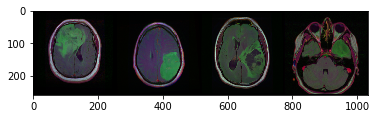

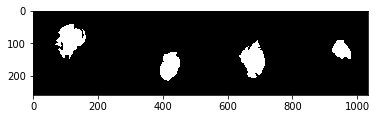

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


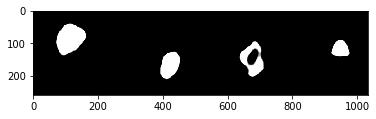

In [25]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision

def imshow(img):
    img = img
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(val_loader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))
imshow(torchvision.utils.make_grid(labels))
images, labels = images.to(device), labels.to(device)
results = net(images)
results = results.cpu().detach()
imshow(torchvision.utils.make_grid(results))

In [26]:
train_losses = np.array(train_losses)
val_losses = np.array(val_losses)

print(train_losses.shape, val_losses.shape)

(100,) (100,)


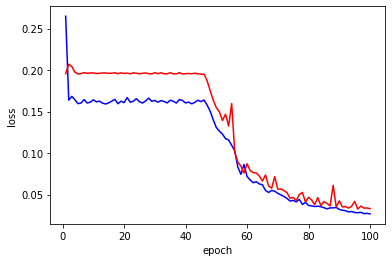

In [27]:
x = np.arange(1, 101, 1)

plt.plot(x, train_losses,'b', label='train loss')
plt.plot(x, val_losses,'r', label='val loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()